# Custom dataset loading using tf.data.Dataset with Tensorflow 2

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load original dataframe

Our target dataset is stored in _CSV_ format. There are multiple columns, but we are interested in image and corresponded label only.

First of all, let's load _pandas.DataFrame_ and take a look to data. There are column _in_file_, _class_id_ and _class_.

In [2]:
path_to_dataset = './Data/fewshots.csv'
df = pd.read_csv(path_to_dataset)
df.sample(3)

,Unnamed: 0,class,in_file,out_file,x_min,y_min,x_max,y_max,x_center,y_center,width,height,class_id
5754,4,coffin,./Data/coffin/3.jpg,./Data/coffin/3.png,0.223214,0.205357,0.950893,0.736607,0.587054,0.470982,0.727679,0.531250,575
7516,6,grey_fox,./Data/grey_fox/2.jpg,./Data/grey_fox/2.png,0.165179,0.071429,0.928571,0.897321,0.546875,0.484375,0.763393,0.825893,751
2981,1,bell,./Data/bell/10.jpg,./Data/bell/10.png,0.223214,0.245536,0.852679,0.825893,0.537946,0.535714,0.629464,0.580357,298


## Create dictionary of class names

In [3]:
df_class_id_names = df.drop_duplicates(subset=['class'])[['class', 'class_id']]

class_id_names  = dict(list(df_class_id_names.apply(lambda r: (r['class_id'], r['class']), axis=1)))

But we are really interested in image data stored by certain path. It is good idea to create function that accepts image path and returns its content.

**Note!** _tf.image.resize_ returns value has the same type as _images_ if _method_ is _ResizeMethod.NEAREST_NEIGHBOR_. Otherwise, the returns value has type
_float32_.

In [4]:
def load_img(path):
    data = tf.io.read_file(path)
    img = tf.image.decode_jpeg(contents=data, channels=3)
    img = tf.image.resize(img, [224, 224])
    img /= 255.0
    return img

## Create base of dataset

_path_ds_ if instance of _tf.data.Dataset_. It can iterate over list of given names

In [5]:
path_ds = tf.data.Dataset.from_tensor_slices(df.in_file.to_numpy())
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

## Map image decoding to dataset

We can use _tf.data.Dataset.map_ function in order to map some function to each element of dataset. There we map _load_img_ function. Now, our dataset can iterate over images!

Note, than shape of images are defined. This is why we explicitly specify number of channels in _tf.image_decode_jpeg_ and resize image to static shape in _tf.image.resize_ (see _load_img_ function above).

In [6]:
image_ds = path_ds.map(load_img, num_parallel_calls=4)
image_ds

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

## Create label dataset

Dataset above contains all images in dataset but no label information. Let's create label dataset as separate dataset and then merge two datasets in some way.

In [7]:
label_ds = tf.data.Dataset.from_tensor_slices(df.class_id.to_numpy())
label_ds

<TensorSliceDataset shapes: (), types: tf.int64>

## Merge datasets

Now, we have two datasets: with images and with labels. We can merge them using _tf.data.Dataset.zip_. This method have similar semantics to the buil-in _zip_ function in python. _tf.data.Dataset.shuffle_ is used for randomizing dataset. This method should be used after zipping two dataset. In other way you run under risk to mismatch image and labels.

Note, that all shapes are known.

In [8]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds = image_label_ds.shuffle(len(df));
image_label_ds

<ShuffleDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

## Visualize dataset

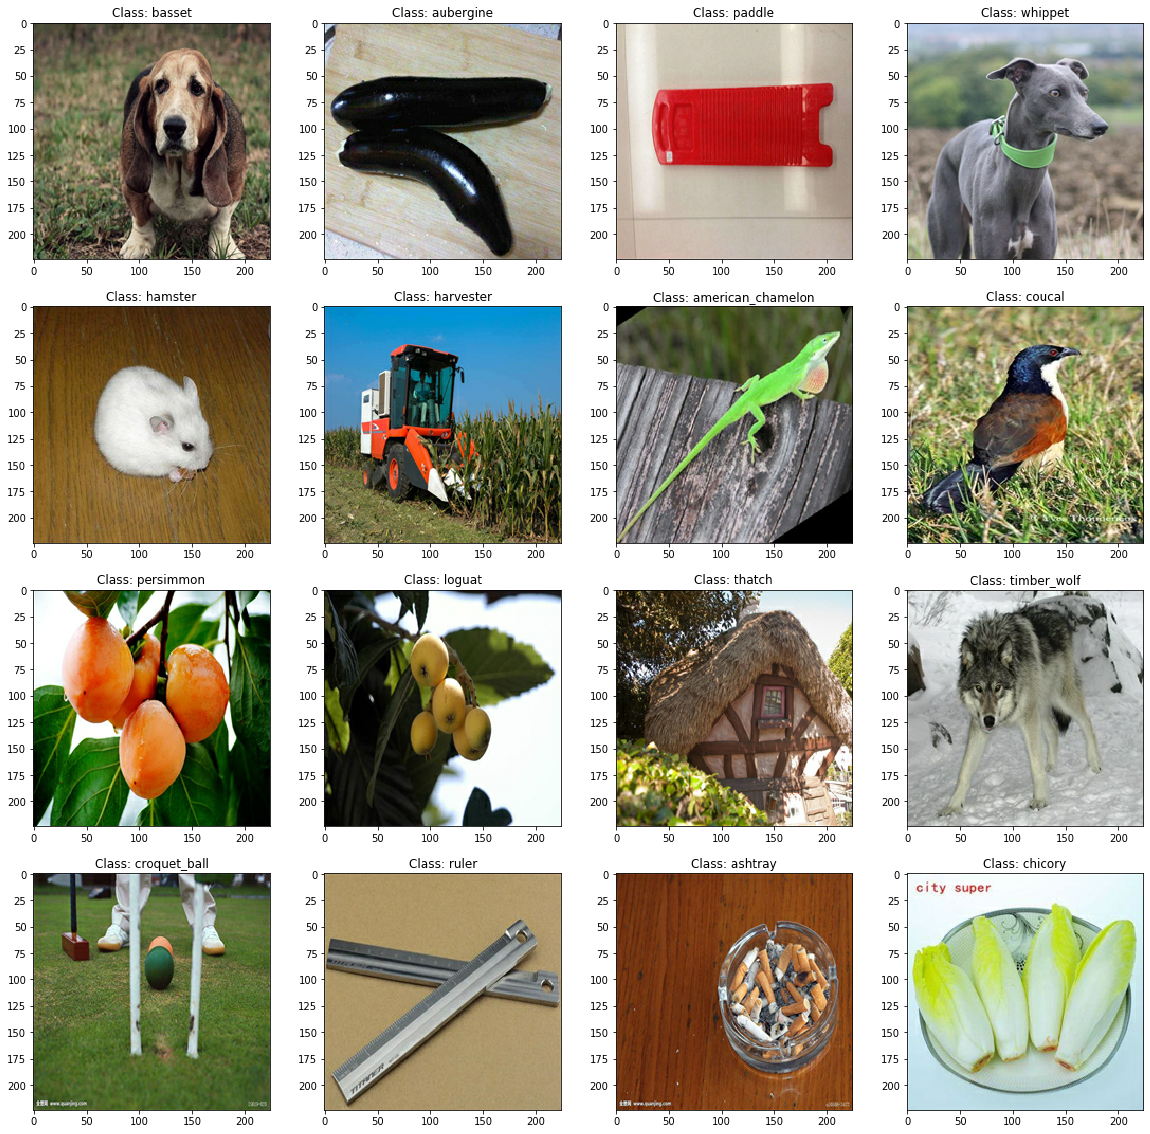

In [9]:
ncols = 4
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))
ax = ax.flatten()

for idx, (img, label) in enumerate(image_label_ds.take(ncols*nrows)):
    ax[idx].imshow(img)
    ax[idx].set_title('Class: {}'.format(class_id_names[label.numpy()]))